# Load Data

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file, _raise, normalize
#from skimage.segmentation import find_boundaries

#from stardist import edt_prob, star_dist, dist_to_coord, polygons_to_label, fill_label_holes
#from stardist import random_label_cmap, draw_polygons, ray_angles
#from stardist import non_maximum_suppression

#np.random.seed(42)
#lbl_cmap = random_label_cmap()

In [2]:
download_and_extract_zip_file(
    url       = 'https://github.com/mpicbg-csbd/stardist/releases/download/0.1.0/dsb2018.zip',
    targetdir = 'data',
    verbose   = False,
)

In [3]:
X = sorted(glob('data/dsb2018/train/images/*.tif'))
Y = sorted(glob('data/dsb2018/train/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [4]:
X = list(map(imread,X))
Y = list(map(imread,Y))

In [5]:
X = [normalize(x,1,99.8) for x in X]

# Gunpowder

In [6]:
import gunpowder as gp

/home/uschmidt/sw/anaconda3/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#x = np.random.uniform(size=(128,128))
from skimage.data import camera
x = camera()

#from tifffile import imread
#x = imread('/home/uschmidt/research/csbdeep/examples/examples/denoising3D/data/tribolium/train/GT/nGFP_0.1_0.2_0.5_20_13_late.tif')
x.shape

src = gp.NumpySource({'x':x,'y':x>128})
#src.setup()
src

request = BatchRequest()
#request.add(ArrayKey('x'),(64,64)) #same
#request[ArrayKey('x')] = ArraySpec(roi=Roi((0,0),(64,128)))
#request[ArrayKey('x')] = ArraySpec(roi=Roi((0,0),(64,128)),voxel_size=Coordinate((1,1)))
request[ArrayKey('x')] = ArraySpec(roi=Roi((0,0),(128,128)))
request[ArrayKey('y')] = ArraySpec(roi=Roi((0,0),(128,128)))

#request[ArrayKey('x')] = ArraySpec(roi=Roi((1,100,1),(1,773-1,665-1)))
#request[ArrayKey('x')] = ArraySpec(roi=Roi((0,0,0),(1,773,665))) # doesn't work, but should -> bug!

#request[ArrayKey('x')] = ArraySpec(roi=None)
request

In [7]:
src = tuple(gp.NumpySource({'x':x,'y':y>0},interpolatable={'x':True,'y':False}) for x,y in zip(X,Y))

In [8]:
request = gp.BatchRequest()
request.add(gp.ArrayKey('x'),(128,128))
request.add(gp.ArrayKey('y'),(128,128))
request


	x: ROI: [0:128, 0:128] (128, 128), voxel size: None, interpolatable: None, dtype: None
	y: ROI: [0:128, 0:128] (128, 128), voxel size: None, interpolatable: None, dtype: None

#pipeline = src
pipeline = src + gp.RandomProvider() + RandomLocation()
#pipeline = src[0] + RandomLocation()
with gp.build(pipeline):
    for i in range(5):
        t = pipeline.request_batch(request)
        #type(t), t
        #dir(t)
        img = t.arrays[ArrayKeys.x].data
        lbl = t.arrays[ArrayKeys.y].data
        #img.shape
        fix,ax = plt.subplots(1,2)
        ax.flat[0].imshow(np.squeeze(img))
        ax.flat[1].imshow(np.squeeze(lbl))

In [9]:
def keras_generator(batch_size=2):
    pipeline = src + gp.RandomProvider() + gp.RandomLocation() + gp.SimpleAugment()
    with gp.build(pipeline):
        while True:
            img,lbl = [],[]
            for _ in range(batch_size):
                t = pipeline.request_batch(request)
                img.append(t.arrays[gp.ArrayKeys.x].data)
                lbl.append(t.arrays[gp.ArrayKeys.y].data)
            yield np.expand_dims(np.stack(img),-1), np.expand_dims(np.stack(lbl),-1)

In [10]:
gen = keras_generator()

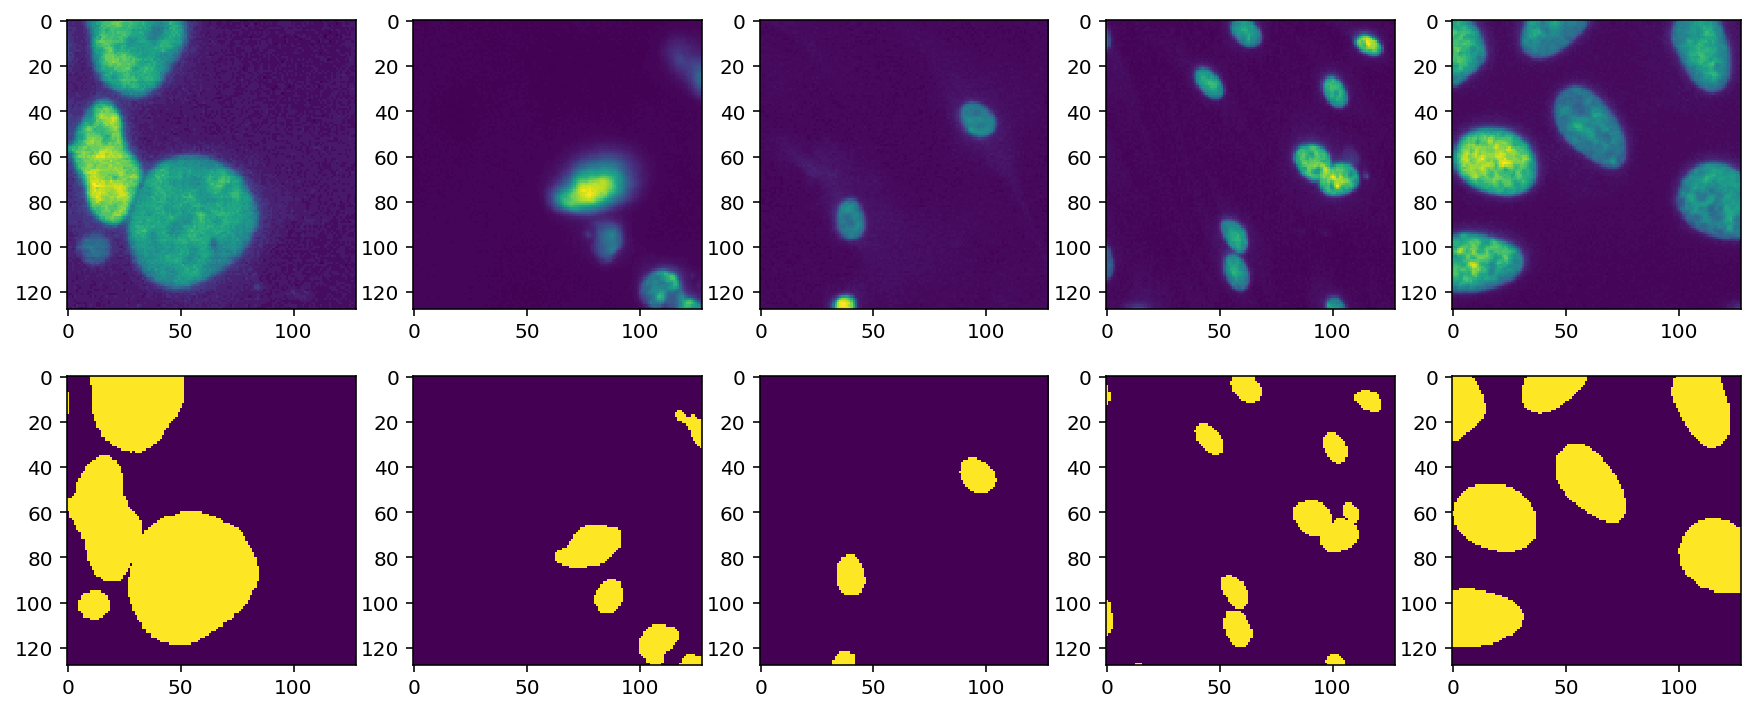

In [11]:
fig,ax = plt.subplots(2,5, figsize=(15,6))
for i in range(5):
    img,lbl = next(gen)
    ax[0,i].imshow(img[0,...,0])
    ax[1,i].imshow(lbl[0,...,0])
None;

In [12]:
from csbdeep.internals.nets import unet_block
from keras.models import Model, Input
from keras.layers import Conv2D
from keras.optimizers import Adam

def get_model(input_shape=(None,None,1), **unet_kwargs):
    inp_X = Input(input_shape,name='X')
    unet = unet_block(**unet_kwargs)(inp_X)
    oup  = Conv2D(1,(1,1),name='Y',padding='same',activation='sigmoid')(unet)
    return Model(inp_X,oup)

Using TensorFlow backend.


In [13]:
model = get_model(n_depth=3, n_filter_base=32)
model.compile(Adam(lr=3e-4), loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

In [14]:
from csbdeep.utils.tf import CARETensorBoard
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
callbacks = []
#callbacks.append(ReduceLROnPlateau(factor=0.5,patience=10))
#callbacks.append(CARETensorBoard(model_name,write_images=True,prefix_with_timestamp=False))
#callbacks.append(ModelCheckpoint('%s/weights_best.h5'%model_name,save_best_only=True,save_weights_only=True))

In [15]:
epochs          = 10
steps_per_epoch = 50
hist = model.fit_generator(epochs=epochs, steps_per_epoch=steps_per_epoch, generator=gen,
                           validation_data=None, callbacks=callbacks)
#model.save_weights('%s/weights_last.h5'%model_name)

Epoch 1/10
50/50 [==============================] - 5s 97ms/step - loss: 0.3910 - acc: 0.9099
Epoch 2/10
50/50 [==============================] - 1s 24ms/step - loss: 0.0937 - acc: 0.9646
Epoch 3/10
50/50 [==============================] - 1s 22ms/step - loss: 0.0812 - acc: 0.9715
Epoch 4/10
50/50 [==============================] - 1s 22ms/step - loss: 0.0731 - acc: 0.9736
Epoch 5/10
50/50 [==============================] - 1s 24ms/step - loss: 0.0570 - acc: 0.9786
Epoch 6/10
50/50 [==============================] - 1s 23ms/step - loss: 0.0450 - acc: 0.9836
Epoch 7/10
50/50 [==============================] - 1s 26ms/step - loss: 0.0658 - acc: 0.9756
Epoch 8/10
50/50 [==============================] - 1s 23ms/step - loss: 0.0568 - acc: 0.9793
Epoch 9/10
50/50 [==============================] - 1s 22ms/step - loss: 0.0511 - acc: 0.9812
Epoch 10/10
50/50 [==============================] - 1s 23ms/step - loss: 0.0557 - acc: 0.9794


class NumpySource(BatchProvider):
    
    def __init__(self, array_dict, voxel_size=None, interpolatable=None):
        self.array_dict = array_dict
        self.voxel_size = voxel_size
        self.interpolatable = interpolatable
    
    def _guess_interpolatable(self,array_key, dtype):
        interpolatable = dtype in [
            np.float,
            np.float32,
            np.float64,
            np.float128,
            np.uint8 # assuming this is not used for labels
        ]
        #logger.warning("WARNING: You didn't set 'interpolatable' for %s. "
        #               "Based on the dtype %s, it has been set to %s. "
        #               "This might not be what you want.",
        #               array_key, dtype, interpolatable)
        return interpolatable
    
        
    def setup(self):
        for key, data in self.array_dict.items():
            if self.voxel_size is None:
                voxel_size = Coordinate((1,)*data.ndim)
            elif isinstance(self.voxel_size,(list,tuple)):
                voxel_size = Coordinate(self.voxel_size)
            else:
                assert key in self.voxel_size
                voxel_size = Coordinate(self.voxel_size[key])
            assert isinstance(voxel_size,Coordinate)
            assert len(voxel_size) == data.ndim

            if self.interpolatable is None:
                interpolatable = self._guess_interpolatable(key,data.dtype)
            elif key in self.interpolatable:
                interpolatable = self.interpolatable[key]
            interpolatable = bool(interpolatable)
            
            self.provides(
                ArrayKey(key),
                ArraySpec(
                    roi            = Roi((0,)*data.ndim, data.shape),
                    dtype          = data.dtype,
                    voxel_size     = voxel_size,
                    interpolatable = interpolatable,
                )
            )

    def provide(self, request):
        print(request)
        for key, request_spec in request.array_specs.items():
            print(key,request_spec)
            spec = self.spec[self.key].copy()
            request_spec = request[self.key]
            # not checked by BatchProvider.check_request_consistency:
            request_spec.dtype is None or request_spec.dtype==spec.dtype or _raise(ValueError("dtype mismatch"))
            #print(f"provider spec = {spec}")
            #print(f"request  spec = {request_spec}")
            array = Array(self.data, spec)
            if request_spec.roi is not None and request_spec.roi != spec.roi:
                array = array.crop(request_spec.roi, copy=True)
            batch = Batch()
            batch.arrays[self.key] = array
            return batch